/tmp/ipython-input-3911248904.py:13: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'the-movies-dataset' dataset.
Loaded dataset: (45476, 3) rows
Graph built with 6240 actors and 114788 edges


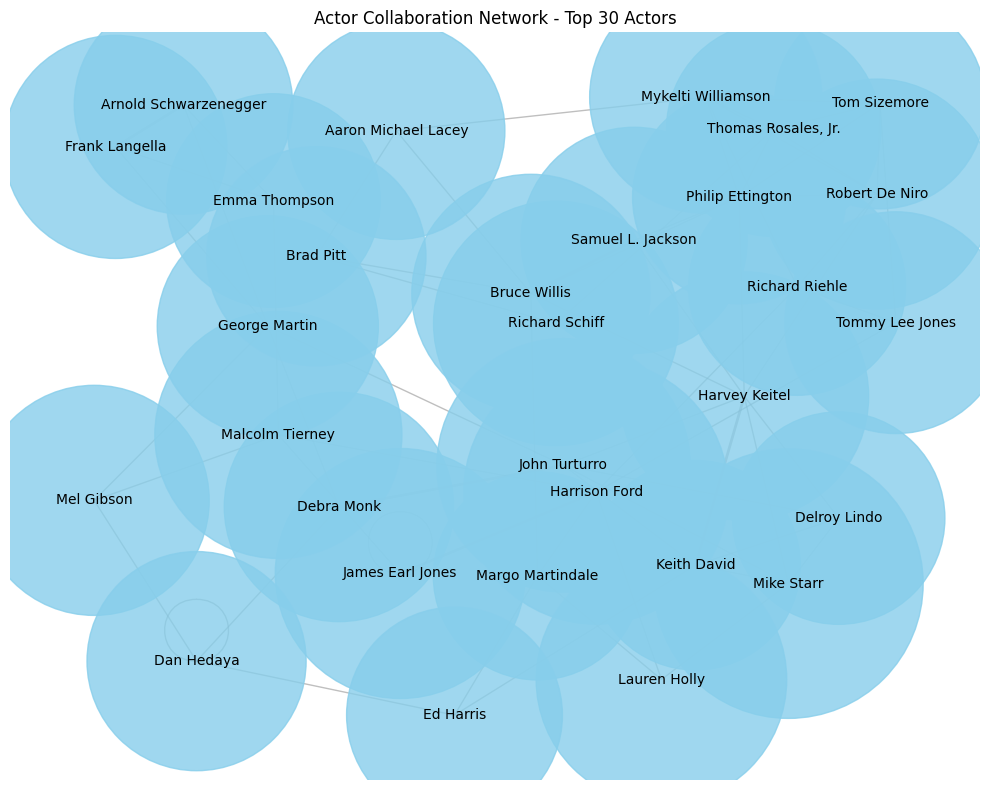

In [ ]:
# Install dependencies if needed:
# pip install kagglehub networkx matplotlib pandas

import kagglehub
from kagglehub import KaggleDatasetAdapter
import ast
import networkx as nx
import matplotlib.pyplot as plt

def load_credits_dataset():
    # Load "credits.csv" from the movies dataset
    file_path = "credits.csv"
    df = kagglehub.load_dataset(
        KaggleDatasetAdapter.PANDAS,
        "rounakbanik/the-movies-dataset",
        file_path,
    )
    print(f"Loaded dataset: {df.shape} rows")
    return df

def build_actor_network(df, max_movies=500):
    """
    Build a network graph where nodes = actors,
    edges connect actors who co-starred in the same movie,
    edge weight = number of movies together.
    """
    G = nx.Graph()

    # Optional: limit number of movies processed to speed up
    df_sample = df.head(max_movies)

    for _, row in df_sample.iterrows():
        try:
            cast_list = ast.literal_eval(row['cast'])
            actors = [actor['name'] for actor in cast_list if 'name' in actor]
        except Exception:
            continue

        # Add edges between every pair of actors in the same movie
        for i in range(len(actors)):
            for j in range(i+1, len(actors)):
                actor1, actor2 = actors[i], actors[j]
                if G.has_edge(actor1, actor2):
                    G[actor1][actor2]['weight'] += 1
                else:
                    G.add_edge(actor1, actor2, weight=1)

    print(f"Graph built with {G.number_of_nodes()} actors and {G.number_of_edges()} edges")
    return G

def plot_network(G, top_n=30):
    """
    Plot the subgraph of top_n actors by degree.
    Node size and edge width correspond to degree and weight.
    """
    # Get top_n nodes by degree
    degree_dict = dict(G.degree())
    top_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:top_n]
    subgraph = G.subgraph(top_nodes)

    plt.figure(figsize=(10,8))
    pos = nx.spring_layout(subgraph, k=0.5, iterations=50, seed=42)

    node_sizes = [degree_dict[node] * 150 for node in subgraph.nodes()]
    edge_widths = [subgraph[u][v]['weight'] for u, v in subgraph.edges()]

    nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color='skyblue', alpha=0.8)
    nx.draw_networkx_edges(subgraph, pos, width=edge_widths, alpha=0.5, edge_color='gray')
    nx.draw_networkx_labels(subgraph, pos, font_size=10)

    plt.title(f"Actor Collaboration Network - Top {top_n} Actors")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def main():
    df = load_credits_dataset()
    G = build_actor_network(df, max_movies=500)  # Adjust max_movies for speed/size tradeoff
    plot_network(G, top_n=30)

if __name__ == "__main__":
    main()
